# 1. Configuration, Imports et Chargement des Données


In [2]:
from lifelines.datasets import load_lung
help(load_lung)

Help on function load_lung in module lifelines.datasets:

load_lung(**kwargs)
    Survival in patients with advanced lung cancer from the North Central Cancer Treatment Group. Performance scores rate how well the patient can perform usual daily activities.
    
    
    ::
        Size: (288,10)
        Example:
         inst  time  status  age  sex  ph.ecog  ph.karno  pat.karno  meal.cal  wt.loss
          3.0   306       1   74    1      1.0      90.0      100.0    1175.0      NaN
          3.0   455       1   68    1      0.0      90.0       90.0    1225.0     15.0
          3.0  1010       0   56    1      0.0      90.0       90.0       NaN     15.0
          5.0   210       1   57    1      1.0      90.0       60.0    1150.0     11.0
          1.0   883       1   60    1      0.0     100.0       90.0       NaN      0.0
    
    References
    -----------
    Loprinzi CL. Laurie JA. Wieand HS. Krook JE. Novotny PJ. Kugler JW. Bartel J. Law M. Bateman M. Klatt NE. et al. Prospective

In [ ]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
from matplotlib import pyplot as plt
from pymc.distributions.timeseries import GaussianRandomWalk 
from pytensor import tensor as T
import warnings
# --- NOUVEL IMPORT ---
from lifelines.datasets import load_lung

# --- CONFIGURATION ---
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
n_samples = 1000
n_tune = 1000

warnings.filterwarnings('ignore', category=UserWarning, message='Found a random variable that was neither among the observations nor the conditioned variables')
print(f"Running on PyMC v{pm.__version__}")


# --- CHARGEMENT ET PRÉPARATION DES DONNÉES  ---
try:
    print("Chargement du dataset 'lung' de lifelines...")
    df = load_lung()
except Exception as e:
    print(f"Erreur de chargement. Erreur: {e}")
    raise

# --- BLOC DE PRÉPARATION ADAPTÉ POUR WT.LOSS ---
# 1. Gestion de la variable 'event' (status: 2=événement, 1=censuré)
df['event'] = (df['status'] == 1).astype(np.int64)
# 'time' est déjà au bon format (en jours)

# 2. Gestion de la covariable 'wt.loss' (perte de poids)

# Comptage des NaN value 
total_count = len(df['wt.loss'])
nan_count = df['wt.loss'].isnull().sum()
print(f"Données 'wt.loss': {nan_count} valeurs nulles sur {total_count} au total ({nan_count/total_count:.1%}).")

# 2a. Imputation des NaNs (remplacement par la moyenne)
wt_loss_mean = df['wt.loss'].mean()

df['wt.loss'] = df['wt.loss'].fillna(wt_loss_mean)
print(f"Valeurs manquantes de 'wt.loss' remplacées par la moyenne : {wt_loss_mean:.2f}")

# 2b. Standardisation de la variable (centrer-réduire)
wt_loss_std_dev = df['wt.loss'].std()
# On crée une nouvelle colonne pour le modèle
df['wt_loss_std'] = (df['wt.loss'] - wt_loss_mean) / wt_loss_std_dev
# --- FIN DES MODIFICATIONS DE PRÉPARATION ---

n_patients = df.shape[0]
patients = np.arange(n_patients)

print("\nAperçu des données (Colonnes adaptées du dataset 'lung'):")
# Nous affichons les colonnes que le notebook utilisera
print(df[['time', 'event', 'wt.loss', 'wt_loss_std']].head())

Running on PyMC v5.26.1
Chargement du dataset 'lung' de lifelines...
Valeurs manquantes de 'wt.loss' remplacées par la moyenne : 9.83

Aperçu des données (Colonnes adaptées du dataset 'lung'):
   time  event    wt.loss  wt_loss_std
0   306      1   9.831776     0.000000
1   455      1  15.000000     0.406043
2  1010      0  15.000000     0.406043
3   210      1  11.000000     0.091782
4   883      1   0.000000    -0.772437


# 2. Préparation du Modèle Poisson et Visualisation des Durées


Nombre d'intervalles de temps (lambda0): 35


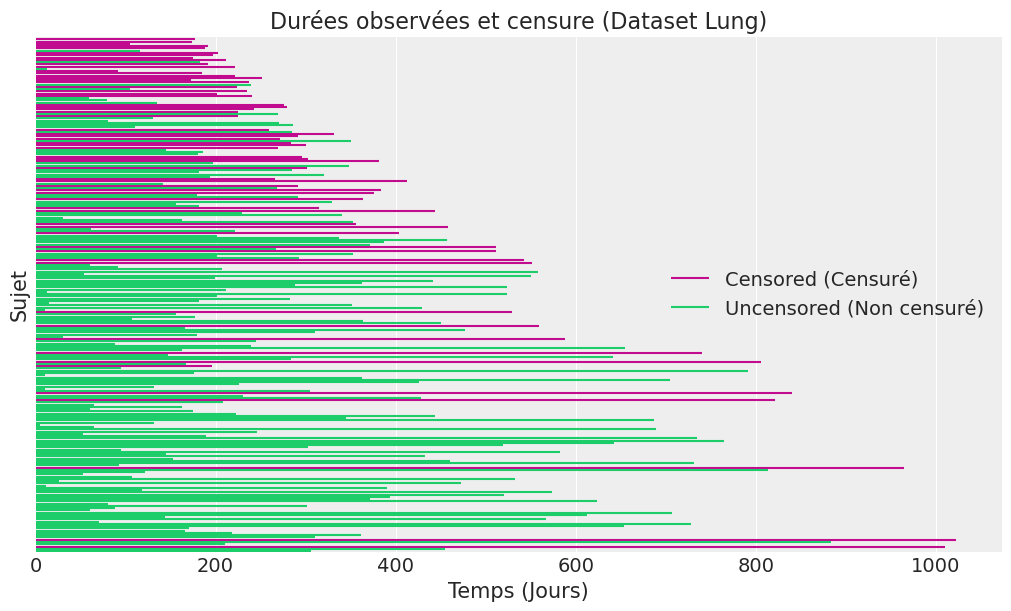

In [6]:
# --- PRÉ-TRAITEMENT POUR L'APPROXIMATION POISSON ---

# Définir les intervalles de temps pour le modèle d'aléa par morceaux
# NOTE : Le temps pour 'lung' est en jours. 
# Choisissons des intervalles de 30 jours (environ 1 mois)
interval_length = 30
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

# 1. Variable indicatrice 'death' (d_i,j)
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)
death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.event 

# 2. Temps à risque 'exposure' (t_i,j)
exposure = np.greater_equal.outer(df.time.to_numpy(), interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

print(f"Nombre d'intervalles de temps (lambda0): {n_intervals}")


# --- VISUALISATION DES DONNÉES BRUTES ET CENSURE ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.hlines(
    patients[df.event.values == 0],
    0,
    df[df.event.values == 0].time,
    color="C3",
    label="Censored (Censuré)",
)
ax.hlines(
    patients[df.event.values == 1],
    0,
    df[df.event.values == 1].time,
    color="C7",
    label="Uncensored (Non censuré)",
)


ax.set_xlim(left=0)
ax.set_xlabel("Temps (Jours)") # Étiquette mise à jour
ax.set_yticks([])
ax.set_ylabel("Sujet")
ax.set_ylim(-0.25, n_patients + 0.25)
ax.legend(loc="center right")
plt.title("Durées observées et censure (Dataset Lung)") # Titre mis à jour
plt.show()

# 3. Modèle 1 : Aléas Proportionnels (Beta Constant) et Inférence

--- 1. MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA CONSTANT) ---
Échantillonnage du Modèle 1...


Initializing NUTS using jitter+adapt_diag...
/Users/jordan/miniconda3/envs/general/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:3004: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Sequential sampling (2 chains in 1 job)
NUTS: [lambda0, beta]


Output()

/Users/jordan/miniconda3/envs/general/lib/python3.11/site-packages/pytensor/tensor/blas.py:239: RuntimeWarning: 
invalid value encountered in dot
  out = np.dot(A, x)

/Users/jordan/miniconda3/envs/general/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: 
RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 371 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Ratio d'aléa moyen (exp(beta)) pour 1 SD de perte de poids : 1.0204


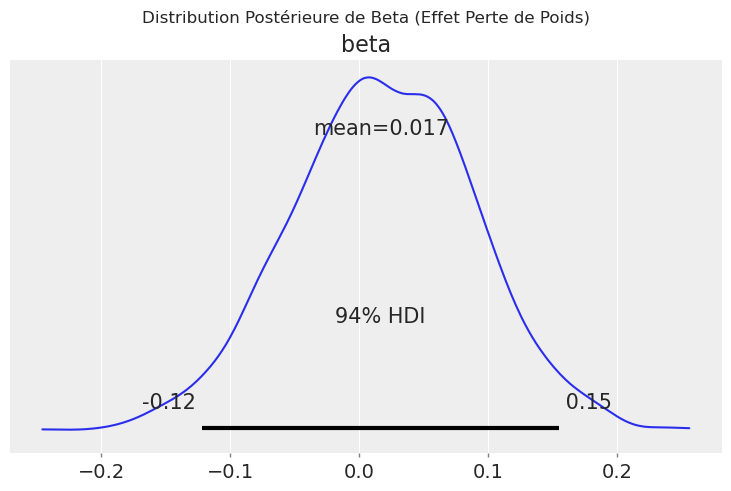

In [11]:
# --- MODÈLE D'ALÉAS PROPORTIONNELS BAYÉSIEN (BÊTA CONSTANT) ---
print("--- 1. MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA CONSTANT) ---")

coords = {"intervals": intervals}
with pm.Model(coords=coords) as model:
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
    beta = pm.Normal("beta", 0, sigma=1000)
    
    # --- LIGNE MODIFIÉE ---
    # Taux d'aléa : lambda_j * exp(x_i_std * beta)
    # Nous utilisons la colonne standardisée 'wt_loss_std'
    lambda_ = pm.Deterministic("lambda_", T.outer(T.exp(beta * df.wt_loss_std), lambda0))
    
    mu = pm.Deterministic("mu", exposure * lambda_)
    obs = pm.Poisson("obs", mu, observed=death)
    
    print("Échantillonnage du Modèle 1...")
    idata = pm.sample(
        n_samples,
        tune=n_tune,
        target_accept=0.99,
        random_seed=RANDOM_SEED,
        cores=1 
    )

# Analyse des résultats clés
# exp(beta) est le HR pour 1 unité de X_std, 
# c'est-à-dire l'augmentation du risque pour 1 écart-type de perte de poids en plus.
hazard_ratio = np.exp(idata.posterior["beta"]).mean().item()
print(f"\nRatio d'aléa moyen (exp(beta)) pour 1 SD de perte de poids : {hazard_ratio:.4f}") 

az.plot_posterior(idata, var_names=["beta"])
plt.suptitle("Distribution Postérieure de Beta (Effet Perte de Poids)") # Titre mis à jour
plt.show()

# 4. Visualisation de l'Aléa et de la Survie (Modèle 1)


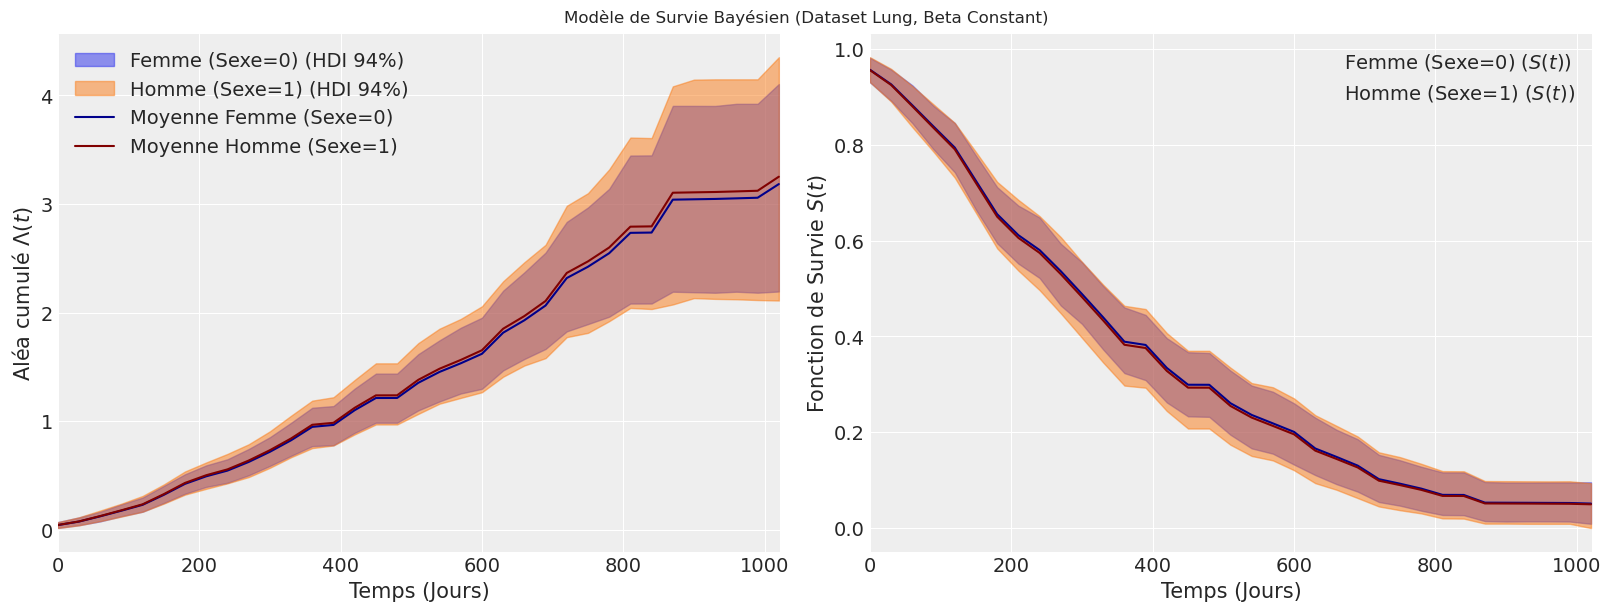

In [16]:
# --- TRACÉS ALÉA CUMULÉ ET SURVIE (MODÈLE 1) ---

# Définition des fonctions pour le calcul (Inchangé)
base_hazard = idata.posterior["lambda0"]
# 'met_hazard' représente maintenant le groupe Homme (Sexe=1)
met_hazard = idata.posterior["lambda0"] * np.exp(idata.posterior["beta"])

def cum_hazard(hazard):
    # Aléa cumulé = somme des (aléa * durée d'intervalle)
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    # Fonction de survie S(t) = exp(-Lambda(t))
    return np.exp(-cum_hazard(hazard))

def get_mean(trace):
    return trace.mean(("chain", "draw"))

fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, figsize=(16, 6))

# Tracé de l'Aléa Cumulé (Étiquettes adaptées)
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(base_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Femme (Sexe=0) (HDI 94%)"}, # Étiquette mise à jour
)
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Homme (Sexe=1) (HDI 94%)"}, # Étiquette mise à jour
)
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(base_hazard)), color="darkblue", label="Moyenne Femme (Sexe=0)") # Étiquette mise à jour
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(met_hazard)), color="maroon", label="Moyenne Homme (Sexe=1)") # Étiquette mise à jour
hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel("Temps (Jours)") # Étiquette mise à jour
hazard_ax.set_ylabel(r"Aléa cumulé $\Lambda(t)$")
hazard_ax.legend(loc=2)

# Tracé de la Fonction de Survie (Étiquettes adaptées)
az.plot_hdi(interval_bounds[:-1], survival(base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(met_hazard), ax=surv_ax, smooth=False, color="C1")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(met_hazard)), color="maroon")
surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel("Temps (Jours)") # Étiquette mise à jour
surv_ax.set_ylabel(r"Fonction de Survie $S(t)$")
surv_ax.legend([r"Femme (Sexe=0) ($S(t)$)", r"Homme (Sexe=1) ($S(t)$)"], loc=1) # Étiquette mise à jour
fig.suptitle("Modèle de Survie Bayésien (Dataset Lung, Beta Constant)"); # Titre mis à jour
plt.show()

# 5. Modèle 2 : Beta variant dans le temps et Visualisation du Ratio d'Aléa


--- 2. MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA VARIANT DANS LE TEMPS) ---
Échantillonnage du Modèle 2...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda0, beta]


Output()

/Users/jordan/miniconda3/envs/general/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: 
RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 501 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


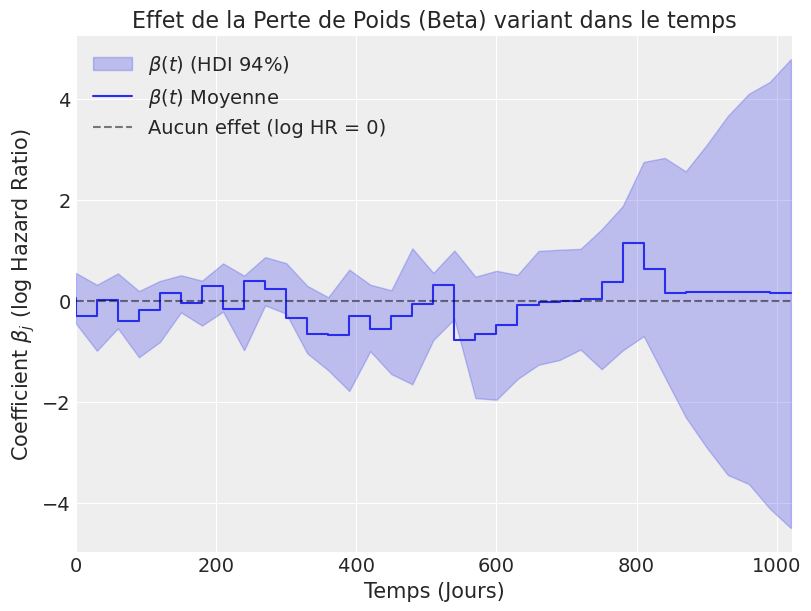

In [7]:
# --- MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA VARIANT DANS LE TEMPS) ---
print("--- 2. MODÈLE D'ALÉAS PROPORTIONNELS (BÊTA VARIANT DANS LE TEMPS) ---")

coords = {"intervals": intervals}
with pm.Model(coords=coords) as time_varying_model:
    # Aléa de base (lambda0) - constant par morceaux, Gamma vague
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
    
    # Coefficient de régression (beta) - modélisé comme une Marche Aléatoire Gaussienne
    beta = GaussianRandomWalk("beta", init_dist=pm.Normal.dist(), sigma=1.0, dims="intervals")
    
    # --- LIGNE MODIFIÉE ---
    # Taux d'aléa : lambda_j * exp(x_i_std * beta_j)
    # Nous utilisons la colonne standardisée 'wt_loss_std'
    lambda_ = pm.Deterministic("h", lambda0 * T.exp(T.outer(T.constant(df.wt_loss_std), beta)))
    
    # Moyenne pour Poisson
    mu = pm.Deterministic("mu", exposure * lambda_)
    
    # Vraisemblance (Approximation de Poisson)
    obs = pm.Poisson("obs", mu, observed=death)

    # Échantillonnage MCMC
    print("Échantillonnage du Modèle 2...")
    time_varying_idata = pm.sample(
        n_samples,
        tune=n_tune,
        return_inferencedata=True,
        target_accept=0.99,
        random_seed=RANDOM_SEED,
        cores=1
    )

# --- TRACÉ DU COEFFICIENT BETA (log-Hazard Ratio) (ADAPTÉ) ---
fig, ax = plt.subplots(figsize=(8, 6))

# Calcul de l'intervalle de crédibilité (HDI à 94%) pour beta
az.plot_hdi(
    interval_bounds[:-1],
    time_varying_idata.posterior["beta"],
    ax=ax,
    smooth=False, 
    color="C0",
    fill_kwargs={"alpha": 0.25, "label": r"$\beta(t)$ (HDI 94%)"}
)

# Récupération de la moyenne postérieure pour le tracé de la ligne
beta_hat = time_varying_idata.posterior["beta"].mean(("chain", "draw"))
ax.step(interval_bounds[:-1], beta_hat, color="C0", where='pre', label=r"$\beta(t)$ Moyenne")

# Ligne de référence à 0 (log(1) = 0, signifiant aucun effet)
ax.axhline(0, color='k', linestyle='--', alpha=0.5, label="Aucun effet (log HR = 0)")

# --- GRAPHIQUES SCATTER SUPPRIMÉS ---
# Les graphiques 'scatter' précédents (pour 'Homme=1') ne sont pas 
# pertinents ici car 'wt.loss' est une variable continue 
# et non une catégorie binaire.

ax.set_xlim(0, df.time.max())
ax.set_xlabel("Temps (Jours)") # Étiquette mise à jour
ax.set_ylabel(r"Coefficient $\beta_j$ (log Hazard Ratio)")
ax.legend()
plt.title("Effet de la Perte de Poids (Beta) variant dans le temps") # Titre mis à jour
plt.show()